In [0]:
import numpy as np
import random
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.utils import shuffle
from IPython.display import clear_output

In [0]:
from collections import namedtuple, deque

class experienceReplayBuffer:
        
    def __init__(self, memory_size=5000):
        self.memory_size   = memory_size
        self.Buffer        = namedtuple('Buffer', field_names=['state', 'action', 'reward'])
        self.replay_memory = deque(maxlen=memory_size)
     
    # Получаем Батч случайных примеров из буфера памяти
    def sample_batch(self, batch_size=64):
        samples = np.random.choice(len(self.replay_memory), batch_size, replace=False)
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch
    
    # Добавление одиночного примера в буфер памяти
    def append(self, state, action, reward):
        self.replay_memory.append(self.Buffer(state, action, reward))
     
    # Добавление Батча примеров в буфер памяти
    def append_butch(self, state_batch, action_batch, reward_batch):
        for i in range(state_batch.shape[0]):
            self.append(state_batch[i],action_batch[i], reward_batch[i]) 
    
    # Очистка буфера памяти
    def clear(self):
        self.replay_memory.clear()
        return 
    # Расчет длины буфера памяти с датасетом
    def print_len_bufer(self):
        return len(self.replay_memory)

In [0]:

##############################################################################################
class Point(object):
    """Точка"""

    def __init__(self, y_in=0, x_in=0, color_in=0.5):
        self.color = color_in  # Цвет точки
        self.y = y_in
        self.x = x_in

    # Функция Установки точки в произвольных координатах
    def set_point_position(self, y_in, x_in):
        self.y = y_in
        self.x = x_in

    # Функция получения координат точки
    def get_point_position(self):
        return (self.y, self.x, self.color)

    # Функция движения точки вниз
    def move_point_down(self):
        self.y += 1

##################################################################################################
class Racket(object):
    """Ракетка Игрока"""

    def __init__(self, width_r_in, color_r_in):
        self.width_r = width_r_in  # Ширина ракетки
        self.color_r = color_r_in  # Цвет ракетки
        self.x_rlc = 0  # Левый угол ракетки х-координата
        self.y_rlc = 0  # Левый угол ракетки х-координата

    # Функция Установки левого угла ракетки в произвольных координатах
    def set_racet_position(self, y_rlc_in, x_rlc_in):
        self.y_rlc = y_rlc_in
        self.x_rlc = x_rlc_in

    # Функция движения ракетки влево
    def move_racet_left(self):
        if self.x_rlc >= 1:
            self.x_rlc -= 1  # Left

    # Функция движения ракетки вправо
    def move_racet_right(self):
        if self.x_rlc + self.width_r < self.width_w:
            self.x_rlc += 1  # Right

    # Функция движения ракетки вверх
    def move_racet_up(self):
        if self.y_rlc >= 1:
            self.y_rlc -= 1  # Up

    # Функция движения ракетки вниз
    def move_racet_down(self):
        if self.y_rlc < self.high_w - 1:
            self.y_rlc += 1  # Down

    # Функция движения ракетки вверх и лево
    def move_racet_up_left(self):
        if (self.y_rlc >= 1) & (self.x_rlc >= 1):  # Если вверх и влево в границах колодца
            self.move_racet_up()  # Up
            self.move_racet_left()  # left

    # Функция движения ракетки вверх и вправо
    def move_racet_up_right(self):
        if (self.y_rlc >= 1) & (self.x_rlc + self.width_r < self.width_w):  # Если вверх и вправо в границах колодца
            self.move_racet_up()  # Up
            self.move_racet_right()  # Right

    # Функция движения ракетки вниз и лево
    def move_racet_down_left(self):
        if (self.y_rlc < self.high_w - 1) & (self.x_rlc >= 1):  # Если вниз и влево в границах колодца
            self.move_racet_down()  # Down
            self.move_racet_left()  # Left

    # Функция движения ракетки вниз и вправо
    def move_racet_down_right(self):
        if (self.y_rlc < self.high_w - 1) & (self.x_rlc + self.width_r < self.width_w):  # Если вниз и вправо в границах колодца
            self.move_racet_down()   # Down
            self.move_racet_right()  # Right

    # Функция возвращающая список координат блоков ракетки
    def get_list_racet_position(self):
        list_out = []
        for i in range(0, self.width_r):
            racet_block = self.y_rlc, self.x_rlc + i, self.color_r
            list_out.append(racet_block)
        return (list_out)


###############################################################################################
class Weel(Point, Racket):
    """Колодец"""

    def __init__(self, high_w_in, width_w_in, width_racet_g, color_w_in):
        self.high_w = high_w_in  # Высота колодца
        self.width_w = width_w_in  # Ширина колодца
        self.color_w = color_w_in  # Цвет пустого колодца
        self.width_racket_in = width_racet_g  # Ширина ракетки
        self.reset_game()
        
    # Функция сбрасывающая игру в нулевое начальное состояние
    def reset_game(self):
        self.field = np.zeros((self.high_w, self.width_w))  # Пустой Двумерный массив пикселей колодца
        self.list_point = []  # Список Точек

        self.count_point = 0
        self.count_yellow_catch_point = 0
        self.count_yellow_uncatch_point = 0
        self.count_blue_catch_point = 0
        self.count_blue_uncatch_point = 0
        
        # Устанавливаем признак конца игры и конца эпизода в False
        self.done_game = False 

        # Создание ракетки
        Racket.__init__(self, self.width_racet_g, color_r_in=1)
        # Установка ракетки в начальное положение в центре колодца
        self.set_racet_position(self.high_w - 1, (self.width_w - self.width_racket_in) // 2)

        # Создание точки
        self.list_point.append(0)
        self.list_point[0] = Point(y_in=0, x_in=5, color_in=self.list_color_point[0])
        # Установка точки в координаты
        new_x = random.randint(0, self.width_w - 1)
        self.list_point[0].set_point_position(0, new_x)
        self.count_point += 1
#        print ('Игра сброшена','*'*50)

    # Функция добавляющая еще одну точку на пустое поле вверху колодца, min_len - миниммальное растояние между точками
    def add_point_on_top_weel(self, min_len):
        # Проверка на то что бы новая точка была не ближе расстояния min_len
        list_y_point_position = []
        need_add_point = 0

        # Определяем, что точку нужно довалять если список точек пустой
        if len(self.list_point) == 0:
            need_add_point = 1
        # Определяем, что точку нужно довалять если превышено мин.раастояние между точками
        if len(self.list_point) > 0:
            for num_point in self.list_point:
                point_position = np.array(num_point.get_point_position())
                list_y_point_position.append(point_position[0])
            list_y_point_position.sort()
            if list_y_point_position[0] > min_len:
                need_add_point = 1
        # Если нужно, то Добавление новой точки
        if need_add_point == 1:
            if len(self.list_point) < self.max_point_weel_g:
                flag_add = 0
                while flag_add == 0:
                    new_x = random.randint(0, self.width_w - 1)
                    if self.field[0, new_x] == 0:
                        # Случайное Определение цвета для будущей точки
                        point_color = self.list_color_point[0]
                        rnd = random.random()
                        if (rnd < 0.5):
                            point_color = self.list_color_point[1]
                        # Создание и установка точки
                        new_num = len(self.list_point)
                        self.list_point.append(new_num)
                        self.list_point[new_num] = Point(y_in=0, x_in=new_x, color_in=point_color)
                        self.list_point[new_num].set_point_position(0, new_x)
                        self.count_point += 1
                        flag_add = 1

    # Функция двигающая все точки в колодце вниз на 1 шаг
    def move_all_point_down(self):
        # self.impact_point_in_racet()        # Считаем точки точки попавшие в ракетку
        # self.impact_point_on_bootom_weel()  # Считаем точки точки упавшие до дна колодца, пойманные и не пойманные ракеткой
        for num_point in self.list_point:
            num_point.move_point_down()

    # Функция считающая все точки достигшие попавшие в ракетку
    def impact_point_in_racet(self):
        # Получаем список координат ракетки по x
        list_racetki = np.array(self.get_list_racet_position())
        list_racetki = list_racetki[:, 0:2].tolist()
        # print()
        # print(list_racetki)

        for num_point in self.list_point:
            point_position = np.array(num_point.get_point_position())
            short_point_position = point_position[0:2].tolist()
            # print(short_point_position)

            if short_point_position in list_racetki:
                # print('Попадание в ракетку')
                color_impact = point_position[2]
                if color_impact == self.list_color_point[0]:
                    self.count_yellow_catch_point += 1  # поймана точка желтого цвета
                else:
                    self.count_blue_catch_point += 1  # поймана точка синего цвета
                #                print('Правильных попаданий = ', self.count_right_catch_point, \
                #                      '   Неправильных попаданий = ',self.count_wrong_catch_point)
                # Удаление попавшей точки
                #self.list_point.remove(num_point)
    
    # Функция удаляющая все точки попавшие в ракетку            
    def delete_impact_point_in_racet(self):
        # Получаем список координат ракетки по x
        list_racetki = np.array(self.get_list_racet_position())
        list_racetki = list_racetki[:, 0:2].tolist()
       
        for num_point in self.list_point:
            point_position = np.array(num_point.get_point_position())
            short_point_position = point_position[0:2].tolist()
            
            # Удаление попавшей в ракетку точки
            if short_point_position in list_racetki:
                self.list_point.remove(num_point)

    # Функция считающая все точки достигшие дна колодца и не пойманные ракеткой
    def impact_point_on_bootom_weel(self):
        # Получаем список координат ракетки по x
        for num_point in self.list_point:
            if num_point.get_point_position()[0] == self.high_w:  # self.high_w-1:
                #                print('Попадание в Дно колодца')
                color_impact = num_point.get_point_position()[2]
                if color_impact == self.list_color_point[1]:
                    self.count_blue_uncatch_point += 1  # не поймана точка синего цвета
                else:
                    self.count_yellow_uncatch_point += 1  # не поймана точка желтого цвета
                #                print('Правильных попаданий в Дно колодца = ', self.count_right_uncatch_point, \
                #                      '   Правильных попаданий в Дно колодца = ',self.count_wrong_uncatch_point)
                # Удаление попавшей точки
                self.list_point.remove(num_point)
    
    # Функция считающая все точки достигшие дна колодца и не пойманные ракеткой
    def delete_impact_point_on_bootom_weel(self):
        # Получаем список координат ракетки по x
        for num_point in self.list_point:
            if num_point.get_point_position()[0] == self.high_w:  # self.high_w-1:
                # Удаление уппавшей точки и не пойманной ракеткой
                self.list_point.remove(num_point)

    # Функция печатающая состояние колодца (матрицу точек)
    def print_weel_state(self):
        # Обнуляем массив
        self.field = np.zeros((self.high_w, self.width_w))

        # Получаем данные по точкам, заносим их в массив
        for num_point in self.list_point:
            y_p, x_p, c_p = num_point.get_point_position()  # получаем координаты точки и ее цвет
            # print(y_p,x_p,c_p)
            self.field[y_p, x_p] = c_p  # заполням массив колодца

        # Получаем данные по блокам ракетки, заносим их в массив
        list_rpos = self.get_list_racet_position()  # получаем список координаткоординаты блоков ракетки
        for num_block in list_rpos:
            y_r, x_r, c_r = num_block  # заполням массив колодца
            self.field[y_r, x_r] = c_r
        return (pd.DataFrame(self.field).astype(float))
    
    # Функция возвращающаяся состояние колодца (матрицу точек)
    def get_weel_state(self):
        # Обнуляем массив
        self.field = np.zeros((self.high_w, self.width_w))
        # Получаем данные по точкам, заносим их в массив
        for num_point in self.list_point:
            y_p, x_p, c_p = num_point.get_point_position()  # получаем координаты точки и ее цвет
            # print(y_p,x_p,c_p)
            self.field[y_p, x_p] = c_p  # заполням массив колодца
        # Получаем данные по блокам ракетки, заносим их в массив
        list_rpos = self.get_list_racet_position()  # получаем список координаткоординаты блоков ракетки
        #print(list_rpos)
        for num_block in list_rpos:
            y_r, x_r, c_r = num_block  # заполням массив колодца
            self.field[y_r, x_r] = c_r       
        # Поворачиваем массив изображения для Pytorch - работает с ошибкой
        #self.field[:, 0], self.field[:, 1] = self.field[:, 1], self.field[:, 0].copy()
        return (self.field.astype(float))

    # Функция выдающая кол-во созданных точек
    def get_count_point(self):
        return (self.count_point)

    # Функция возвращающая список имеющихся точек
    def get_list_of_point(self):
        return (self.list_point)

    # Функция выдающая кол-во правильно пойманных точек ракеткой
    def get_count_yellow_catch_point(self):
        return (self.count_yellow_catch_point)

    # Функция выдающая кол-во неправильно пойманных точек ракеткой
    def get_count_blue_catch_point(self):
        return (self.count_blue_catch_point)

    # Функция выдающая кол-во правильно пойманных точек ракеткой
    def get_count_yellow_uncatch_point(self):
        return (self.count_yellow_uncatch_point)

    # Функция выдающая кол-во неправильно пойманных точек ракеткой
    def get_count_blue_uncatch_point(self):
        return (self.count_blue_uncatch_point)

    def act_pg(self, action):        
        # Проверяем на окончание игры (кол-во пойманных и непойманных точек равно кол-ву точек на игру)
        sum_catch_point   = self.get_count_yellow_catch_point()   + self.get_count_blue_catch_point()
        sum_uncatch_point = self.get_count_yellow_uncatch_point() + self.get_count_blue_uncatch_point()     
        if sum_catch_point + sum_uncatch_point != kol_point:
            # Запоминаем счет игры
            old_count_game = self.get_game_count_dqn()
            # Запоминаем нулевое состояние среды и счет игры
            #s_0 = self.get_weel_state()

            # Движения в Среде
            self.move_all_point_down()                # Двигаем точки вниз
            self.impact_point_in_racet()              # Считаем точки попавшие в ракетку
            self.impact_point_on_bootom_weel()        # Считем точки упавшие на дно
            self.delete_impact_point_in_racet()       # Удаляем все точки попавшие в ракетку
            self.delete_impact_point_on_bootom_weel() # Удаляем все точки со дна колодца и не пойманные ракеткой

            self.do_what_NN_say(action)               # Делаем предсказание нейросетью
            self.impact_point_in_racet()              # Считаем точки попавшие в ракетку
            self.impact_point_on_bootom_weel()        # Считем точки упавшие на дно           
            self.delete_impact_point_in_racet()       # Удаляем все точки попавшие в ракетку
            self.delete_impact_point_on_bootom_weel() # Удаляем все точки со дна колодца и не пойманные ракеткой

            # Добавляем еще одну точку
            if self.get_count_point() < kol_point:
                self.add_point_on_top_weel(min_len_between_point)  

            # Запоминаем новое состояние среды после все действий
            s_1 = self.get_weel_state()
            # Запоминаем новый счет игры
            new_count_game = self.get_game_count_dqn()

            #Получаем Награду за действие  
            reward = new_count_game - old_count_game
            #print('reward =', reward)   
        
        # Действия если достигнут конец игры
        else:
            self.done_game = True 
            
        return self.done_game
    
    def get_game_count_dqn(self):
        game_count = 0
        sum_drope_point = self.get_count_yellow_catch_point() + self.get_count_blue_catch_point() + self.get_count_yellow_uncatch_point() + self.get_count_blue_uncatch_point()
        if sum_drope_point > 0:
            sum_catch_point   = self.get_count_yellow_catch_point()   + self.get_count_blue_catch_point()
            sum_uncatch_point = self.get_count_yellow_uncatch_point() + self.get_count_blue_uncatch_point()
            game_count = (sum_catch_point - sum_uncatch_point) #/ sum_drope_point
        return game_count
    
    def get_str_game_count_dqn(self):
        sum_drop_point = self.get_count_yellow_catch_point() + self.get_count_blue_catch_point() + self.get_count_yellow_uncatch_point() + self.get_count_blue_uncatch_point()

        string_count = str(sum_drop_point) + ' = ' \
                       + str(self.get_count_yellow_catch_point()) + ':' + str(self.get_count_yellow_uncatch_point()) + ' /  ' \
                       + str(self.get_count_blue_catch_point()) + ':' + str(self.get_count_blue_uncatch_point())
        return string_count
    
    # Функция выдающая кол-во непойманных точек
    def do_what_NN_say(self, what_do):
        if what_do == 0:
            pass

        elif what_do == 1:
            self.move_racet_left()

        elif what_do == 2:
            self.move_racet_right()

        elif what_do == 3:
            self.move_racet_up()

        elif what_do == 4:
            self.move_racet_down()

        elif what_do == 5:
            self.move_racet_up_left()

        elif what_do == 6:
            self.move_racet_up_right()

        elif what_do == 7:
            self.move_racet_down_left()

        elif what_do == 8:
            self.move_racet_down_right()
        else:
            raise NameError('Ошибка в указании действия')

        return what_do

    # Функция переводящая номер действия в текст
    def translate_what_do(self, what_do):
        if what_do == 0:
            return 'Wait'
        elif what_do == 1:
            return 'Left'
        elif what_do == 2:
            return 'Right'
        elif what_do == 3:
            return 'Up'
        elif what_do == 4:
            return 'Down'
        elif what_do == 5:
            return 'Up_Left'
        elif what_do == 6:
            return 'Up_Right'
        elif what_do == 7:
            return 'Down_Left'
        elif what_do == 8:
            return 'Down_Right'
        else:
            raise NameError('Ошибка записанного действия')
            
    # Функция случайно двигающая ракетку
    def deside_what_to_do(self):
        return (self.move_random_racet_left_right())    


##################################################################################################
class Game(Weel):
    """ Игра """

    def __init__(self, higth_weel_g, width_weel_g, width_racet_g, max_point_weel_g, list_col_point=[0.4]):
        self.list_color_point = list_col_point    # Максимальное кол-во цветов точек)
        self.width_racet_g = width_racet_g        # Ширина ракетки
        self.max_point_weel_g = max_point_weel_g  # Максимальное одновременное кол-во точек в колодце
        self.higth_weel_g = higth_weel_g          # Высота колодца
        self.width_weel_g = width_weel_g          # Глубина колодца
        self.buffer = experienceReplayBuffer( memory_size=5000)#, burn_in=1000)

        # Создание колодца
        Weel.__init__(self, higth_weel_g, width_weel_g, width_racet_g, color_w_in=0)



In [0]:
# Одноканальная Игра
def teach_net(buffer, policy_estimator, optimizer, batch_size = 64, device_in='cuda'):
       
    optimizer.zero_grad()  
    # Получаем батч данных из буфера памяти 
    batch = buffer.sample_batch(batch_size=batch_size)
    # Распаковываем батч данных
    states, actions, rewards = [i for i in batch] 
    # Преобразуем в тензоры
    image_tensor  = torch.Tensor(np.expand_dims(states, axis=1)).float().to(device_in)
    score_tensor  = torch.Tensor(rewards).float().to(device_in)
    action_tensor = torch.Tensor(actions).long().to(device_in)
    # Этап 1 - логарифмируем вероятности действий
    prob = torch.log(policy_estimator.predict(image_tensor))
    # Этап 2 - отрицательное среднее произведения вероятностей на награду
    selected_probs = score_tensor * prob[np.arange(len(action_tensor)), action_tensor]
    loss = -selected_probs.mean()
    loss.backward()
    optimizer.step()
    return (selected_probs)

# Для 9 действий
# Обеспечение процесса Игры

def paint_weel(field_in, title_in):
    ax.clear()
    plt.title(title_in, fontsize=12)
    plt.imshow(field_in)
    fig.canvas.draw()
    plt.pause(0.02)  # pause

def save_paint_episode(paint_in, file_name_in, title_for_paint):
    ep_dir_name = './Episode/'
    ep_file_name = file_name_in + '.png'
    plt.title(title_for_paint, fontsize=12)
    plt.imshow(paint_in)
    plt.savefig(ep_dir_name + ep_file_name)
    plt.close('all')

def get_game_count(G):
    game_count = 0
    sum_drope_point = G.get_count_yellow_catch_point() + G.get_count_blue_catch_point() + G.get_count_yellow_uncatch_point() + G.get_count_blue_uncatch_point()
    if sum_drope_point > 0:
        sum_catch_point = G.get_count_yellow_catch_point() + G.get_count_blue_catch_point()
        sum_uncatch_point = G.get_count_yellow_uncatch_point() + G.get_count_blue_uncatch_point()
        game_count = (sum_catch_point - sum_uncatch_point) #/ sum_drope_point
    return game_count


def get_str_game_count(G):
    sum_drop_point = G.get_count_yellow_catch_point() + G.get_count_blue_catch_point() + G.get_count_yellow_uncatch_point() + G.get_count_blue_uncatch_point()

    string_count = str(sum_drop_point) + ' = ' \
                   + str(G.get_count_yellow_catch_point()) + ':' + str(G.get_count_yellow_uncatch_point()) + ' /  ' \
                   + str(G.get_count_blue_catch_point()) + ':' + str(G.get_count_blue_uncatch_point())
    return string_count


action_space = np.arange(9)  # Пространство действий агента
list_images = []  # Список массивов Изображений серии игр
list_muvies = []  # Список Действий Агента
list_scores = []  # Список Результатов серии игр
list_rolout_score = []  # Список Ролаутов Игр
data_set = {}  # Дата Сет для нейросети

###########################################################################################################################
def discount_correct_rewards(r, gamma=0.98): # Дисконтированная награда
    """ take 1D float array of rewards and compute discounted reward """
    r[:-1] = 0 # Обнуляем все значения в массиве кроме последней награды в эпизоде
    discounted_r = np.zeros_like(r, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add

    # discounted_r -= discounted_r.mean()
    # discounted_r /- discounted_r.std()
    return discounted_r


def translate_what_do(what_do):
    if what_do == 0:
        return 'Wait'
    elif what_do == 1:
        return 'Left'
    elif what_do == 2:
        return 'Right'
    elif what_do == 3:
        return 'Up'
    elif what_do == 4:
        return 'Down'
    elif what_do == 5:
        return 'Up_Left'
    elif what_do == 6:
        return 'Up_Right'
    elif what_do == 7:
        return 'Down_Left'
    elif what_do == 8:
        return 'Down_Right'
    else:
        raise NameError('Ошибка записанного действия')


def game_funct(kol_game, policy_estimator):
    rollout_score = 0

    # Сама Игра
    for num_game in range(kol_game):

        game_list_images = []
        game_list_muvies = []
        game_list_scores = []
        
        episode_list_images = []
        episode_list_muvies = []
        episode_list_scores = []
        episode_list_game_count = []
        episode_list_str_count = []

        num_episode = 0
        len_episode = 0

        G = Game(higth_weel_g, width_weel_g, width_racet_g, max_point_weel_g, list_col_point=[0.5, 0.5])

        # Основной Цикл Игры
        done = False
        while done == False:
            
            # Запоминаем состояние награды на начало эпизода
            old_count_game = get_game_count(G)
            
            # Блок выбора действия для Агента
            image = G.get_weel_state() 
            image_tensor  = torch.Tensor(np.expand_dims([image], axis=0)).float()
            prediction = policy_estimator.predict(image_tensor)       # Предсказываем
            if pe.device_in == 'cpu':
                action = np.argmax(prediction.cpu().detach().numpy()) # Получаем решение, что делать 'cpu'
            else:
                action = torch.max(prediction.detach(), 1)[1].item()  # Получаем решение, что делать 'cuda'
            done = G.act_pg(action) # выполняем действие
            
            episode_list_images.append(image)
            episode_list_muvies.append(action)  # Заносим в список действие агента в эпизоде
            episode_list_str_count.append(get_str_game_count(G)) # Заносим в список кол-во пойманных точек в эпизоде
            episode_list_game_count.append(get_game_count(G))    # Заносим в список кол-во счет игры на момент эпизода

            episode_list_scores.append(0)  # Добавляем нулевое значение в список наград эпизода
            len_episode += 1

            # Проверяем Изменеие Счета в Игре

            if old_count_game != get_game_count(G):
                # Формирование награды на конец эпизода
                new_count_game = get_game_count(G)

                # Заполнение списка наград за весь эпизод
                mas = np.zeros((len(episode_list_scores)))
                mas[:] = new_count_game - old_count_game
                mas[:] = discount_correct_rewards(mas[:])
                episode_list_scores = mas.tolist()  # присваиваем всем значения награды в эпизоде награду эпизода

                # Фиксируем списки эпизода в списке игры
                game_list_images.extend(episode_list_images)
                game_list_muvies.extend(episode_list_muvies)
                game_list_scores.extend(episode_list_scores)

                # Очищаем списки эпизода
                episode_list_images = []
                episode_list_muvies = []
                episode_list_scores = []
                episode_list_str_count = []
                episode_list_game_count = []
                
                len_episode = 0
                num_episode += 1

            if paint_game:
                paint_weel(G.get_weel_state(), get_str_game_count(G))


        # Оценка Серии результатов Игр
        rollout_score = rollout_score + get_game_count(G)

        list_images.extend(game_list_images)
        list_muvies.extend(game_list_muvies)
        list_scores.extend(game_list_scores)
    
    data_set_loc = {'image': np.array(list_images),
                    'muvie': np.array(list_muvies),
                    'score': np.array(list_scores)}

    data_set_out = copy.deepcopy(data_set_loc)

    if num_game == kol_game - 1:
        print('Результат серии = ', rollout_score)
        print('Кол-во примеров = ', len(list_images))
        list_rolout_score.append(rollout_score)

        data_set_loc.clear() # Словарь с ДатаСетом
        list_images.clear()  # Список массивов Изображений серии игр
        list_muvies.clear()  # Список Действий Агента
        list_scores.clear()  # Список Результатов серии игр

    return data_set_out['image'], data_set_out['muvie'], data_set_out['score']

list_mean_score = []  # Список усредненных значений

# отрисовка процесса обучения - средний результат серии из 10 игр
def paint_mean_score(num_step):
    step = 10  # Шаг усреднения
    list_mean_score = []  # Список усредненных значений

    if len(list_rolout_score) >= step:
        # Усредняем в обратном порядке
        for num in range(len(list_rolout_score), step, -1):
            mean_score = np.array(list_rolout_score[num - step:num]).mean()
            list_mean_score.append(mean_score)

        list_mean_score = list_mean_score[::-1]  # разворачиваем список
        mn_sc = np.array(list_mean_score)
        fig, subplot = plt.subplots() # доступ к Figure и Subplot
        subplot.plot(mn_sc) # построение графика функции
        gr_dir_name = './Grafics/'
        gr_file_name = str(num_step) + '_' + str(mn_sc[-1]) + '_' + str(kol_point) + '_point_' + 'Conv2D' + '.png'
        plt.title(gr_file_name, fontsize=12)
        #plt.savefig(gr_dir_name + gr_file_name)
        plt.show()
        

In [0]:
# Одно входовая Сеть

# Convolutional neural network (two convolutional layers)
class MyCNNClassifier(nn.Module):
    def __init__(self, in_c, action_size):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        self.fc1 = nn.Linear(1024, 512)
        self.drop_out = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, action_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x_0):
        out_0 = self.layer1(x_0)
        out_0 = self.layer2(out_0)
        out_0 = out_0.reshape(out_0.size(0), -1)
    
        out = F.relu(self.fc1(out_0))
        out = self.drop_out(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        out = self.softmax(out)
        return out


class PolicyEstimator(object):
    def __init__(self, statement_size, action_size, device_in='cuda'):
        self.n_inputs  = statement_size
        self.n_outputs = action_size
        self.device_in = device_in

        # Define Conv network
        self.network = MyCNNClassifier(1, action_size).to(self.device_in)
        print(self.network)

    def predict(self, input_0):
        action_probs = self.network.forward(input_0.to(self.device_in))
        return action_probs

In [0]:
higth_weel_g = 32  # глубина колодца
width_weel_g = 16  # ширина  колодца
width_racet_g = 4  # ширина  ракетки
max_point_weel_g = 3  # максимальное одновременное кол-во точек в колодце
min_len_between_point = 17  # минимальное расстояние между точками
kol_point = 3  # количество точек падающих за игру

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

pe = PolicyEstimator(statement_size=higth_weel_g * width_weel_g, action_size=9, device_in = device)

Using device: cpu
MyCNNClassifier(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (drop_out): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=9, bias=True)
  (softmax): Softmax(dim=1)
)


tensor([-1.1449e-07, -8.4089e-05, -1.2565e-03, -3.1197e-07,  0.0000e+00,
        -1.7609e-07,  0.0000e+00, -4.8315e-02, -2.6021e-03, -1.5380e-01,
        -2.6244e-02,  0.0000e+00,  0.0000e+00, -1.2325e-05,  0.0000e+00,
        -6.7646e-07,  0.0000e+00, -1.9091e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -1.4305e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -5.0490e-01, -5.8487e-04,  0.0000e+00,
        -2.8957e-04, -1.1099e-05, -4.5795e-07, -8.6283e-08, -3.6206e-03,
        -3.5832e-04, -1.9481e-07, -2.9770e-04,  0.0000e+00, -1.2446e-04,
         0.0000e+00,  0.0000e+00, -2.9221e-07, -1.2599e-02, -1.4586e-06,
        -8.0311e-05, -2.6872e-02, -4.4005e-06, -1.3590e-03, -1.0560e-07,
         0.0000e+00, -2.7679e-03,  0.0000e+00, -1.2812e-03, -5.4849e-06,
         0.0000e+00,  0.0000e+00, -1.4909e-06, -8.8044e-08, -4.1017e-03,
        -8.9841e-08,  0.0000e+00, -5.4672e-04,  0.0000e+00],
       grad_fn=<MulBackward0>)


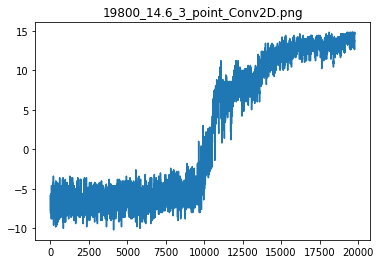

Точность на последних циклах  10  =  14.6
Цикл обучения №  19801
Результат серии =  15
Кол-во примеров =  258
Точность на последних циклах  10  =  14.6
Цикл обучения №  19802
Результат серии =  15
Кол-во примеров =  272
Точность на последних циклах  10  =  14.8
Цикл обучения №  19803
Результат серии =  15
Кол-во примеров =  267
Точность на последних циклах  10  =  14.8
Цикл обучения №  19804
Результат серии =  15
Кол-во примеров =  255
Точность на последних циклах  10  =  14.8
Цикл обучения №  19805
Результат серии =  15
Кол-во примеров =  263
Точность на последних циклах  10  =  15.0
Обучение Закончено


In [0]:
# Одноканальная Игра

paint_game = False  # True #        # Отрисовывать игру или нет (True - отрисовывать)
step = 10  # Шаг усреднения при Анализе обученности
kol_game = 5  # количество игр в цикле обучения

lr_in  = 1e-4
wd_in  = 1e-3

optimAdam = optim.Adam(pe.network.parameters(), lr=lr_in)#, weight_decay=wd_in)
global_buffer = experienceReplayBuffer(memory_size=5000) #, burn_in=1500)

for x in range(0, 100000):
    
    print('Цикл обучения № ', x)
    data_set_images, data_set_actions, data_set_reward = game_funct(kol_game, policy_estimator = pe)
    global_buffer.append_butch(data_set_images, data_set_actions, data_set_reward)
    sel_pr = teach_net(global_buffer, policy_estimator=pe, optimizer = optimAdam, device_in=device)
    global_buffer.clear()
    
    # Анализ степени обученности
    if len(list_rolout_score) >= step:
        if x % 50 == 0:
            clear_output()
            print(sel_pr)
            paint_mean_score(x)

        mean_score = np.array(list_rolout_score[-step:]).mean()
        mean_score = round(mean_score, 2)
        print('Точность на последних циклах ', str(step), ' = ', mean_score)
        if mean_score >= kol_point*kol_game:
            print('Обучение Закончено')
            break

In [0]:
!pip3 install celluloid

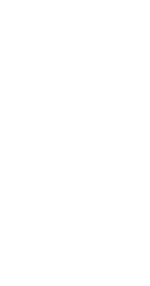

In [0]:
from matplotlib import animation, rc
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, Image # For GIF
from matplotlib import pyplot as plt
from celluloid import Camera

rc('animation', html='jshtml')

fig = plt.figure(figsize=(5, 5))
plt.axis('off')
camera = Camera(fig)
policy_estimator = pe
G = Game(higth_weel_g, width_weel_g, width_racet_g, max_point_weel_g, list_col_point=[0.5, 0.5])

# Основной Цикл Игры
done = False
while done == False:
    # Блок выбора действия для Агента
    image = G.get_weel_state() 
    image_tensor  = torch.Tensor(np.expand_dims([image], axis=0)).float()
    prediction = policy_estimator.predict(image_tensor)       # Предсказываем
    if pe.device_in == 'cpu':
        action = np.argmax(prediction.cpu().detach().numpy()) # Получаем решение, что делать 'cpu'
    else:
        action = torch.max(prediction.detach(), 1)[1].item()  # Получаем решение, что делать 'cuda'
    # выполняем действие
    done = G.act_pg(action) 
    # Отрисовка игры
    plt.imshow(G.get_weel_state())
    camera.snap()
    
    
anim = camera.animate()

anim 


In [0]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
anim.save('/content/drive/My Drive/UAI/Курсовая/smart_2.mp4')
